# Lab №3 Potential field algorithm for path planning
Name: Maha Kahla

To implement the potential field algorithm the robot is treated as a point particle in the configuration space, under the influence of an artificial potential field U. The field U is constructed so that the robot is attracted to the final configuration, while being repelled from the boundaries.

$U(q) = U_{\text{att}}(q) + U_{\text{rep}}(q)$


Given this formulation, path planning can be treated as an optimization problem, One of the easiest algorithms to solve this problem is gradient descent. In this case, the negative gradient of U can be considered as a force acting on the robot.

In this lab we chose to combine the quadratic and conic potentials so that the conic potential attracts the robot when it is very distant from qfinal and the quadratic potential attracts the robot when it is near qfinal.

$$
U_{\text{att}}(q) =
\begin{cases}
\frac{1}{2} \, \zeta \, \rho_f^2(q) & \text{if } \rho_f(q) \le d \\
d \, \zeta \, \rho_f(q) - \frac{1}{2} \, \zeta \, d^2 & \text{if } \rho_f(q) > d
\end{cases}
$$


And we define a potential that goes to infinity at obstacle boundaries, and drops to zero at a certain distance from the obstacle.

$$
U_{\text{rep}}(q) =
\begin{cases}
\frac{1}{2} \, \eta \left( \frac{1}{\rho(q)} - \frac{1}{\rho_0} \right)^2 & \text{if } \rho(q) \le \rho_0 \\
0 & \text{if } \rho(q) > \rho_0
\end{cases}
$$


In our impementation we consider the obstacles to be round shaped and located in the way between the start point and the goal point.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Parameters
k_a = 2.0
k_r = 3.5
delta_0 = 0.06  

# Grid setup
x = np.linspace(0.05, 0.2, 100)
y = np.linspace(0.05, 0.2, 100)
X, Y = np.meshgrid(x, y)
q = np.stack((X, Y), axis=-1)

# Goal position
q_d = np.array([0.16, 0.18])

# Obstacles
obstacles = [
    (np.array([0.1, 0.1]), 0.015),
    (np.array([0.13, 0.14]), 0.015)
]

In [ ]:
def attractive(q, q_d, k_a, d_thresh=0.05):
    rho = np.sqrt((q[..., 0] - q_d[0])**2 + (q[..., 1] - q_d[1])**2)
    U_att = np.where(
        rho <= d_thresh,
        0.5 * k_a * rho**2,
        k_a * d_thresh * rho - 0.5 * k_a * d_thresh**2
    )
    
    return U_att

In [ ]:
# Compute distance to nearest obstacle
def distance_to_obstacles(q, obstacles):
    dist = np.full(q.shape[:2], np.inf)
    for center, radius in obstacles:
        d = np.sqrt((q[..., 0] - center[0])**2 + (q[..., 1] - center[1])**2) - radius
        dist = np.minimum(dist, d)
    return np.clip(dist, 1e-6, None)

# Compute repulsive potential
def repulsive(q, obstacles, k_r, delta_0):
    delta_q = distance_to_obstacles(q, obstacles)
    with np.errstate(divide='ignore', invalid='ignore'):
        rep = np.where(
            delta_q <= delta_0,
            0.5 * k_r * (1.0 / delta_q - 1.0 / delta_0)**2,
            0.0
        )
    return rep

In [5]:
U_att = attractive(q, q_d, k_a, d_thresh=0.05)
U_rep = repulsive(q, obstacles, k_r, delta_0)
U_total = U_att + U_rep

In [6]:
alpha = 1.0
beta = 0.3
U_att_norm = U_att / np.max(U_att)
U_rep_norm = U_rep / np.max(U_rep)
U_total = alpha * U_att_norm + beta * U_rep_norm

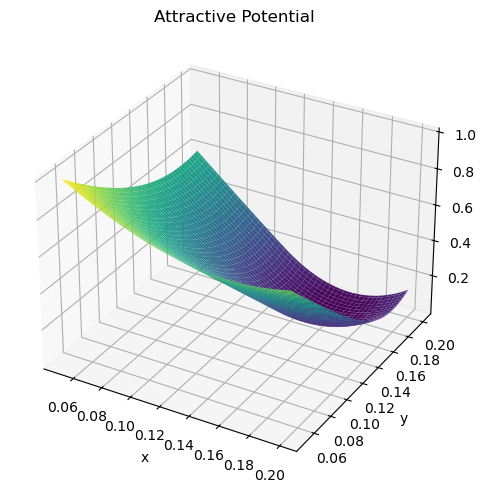

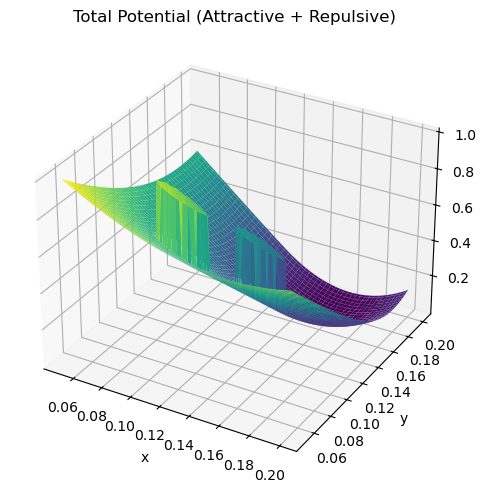

In [14]:
# Plotting 
def plot_surface(Z, title):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.tight_layout()
    plt.show()

plot_surface(U_att_norm, 'Attractive Potential')
plot_surface(U_total, 'Total Potential (Attractive + Repulsive)')


We use a numerical gradient function where it provides accurate central differences inside the domain and proper forward/backward difference at boundaries.

In [8]:
def numerical_gradient(U, h=1.0):
    U_grad_x = np.zeros_like(U)
    U_grad_y = np.zeros_like(U)
    U_grad_x[1:-1, :] = np.clip((U[2:, :] - U[:-2, :]) / (2 * h), -1000,1000)
    U_grad_y[:, 1:-1] = np.clip((U[:, 2:] - U[:, :-2]) / (2 * h), -1000,1000)
    U_grad_x[0, :] = np.clip((U[1, :] - U[0, :]) / h, -1000,1000)
    U_grad_x[-1, :] = np.clip((U[-1, :] - U[-2, :]) / h, -1000,1000)
    U_grad_y[:, 0] = np.clip((U[:, 1] - U[:, 0]) / h, -1000,1000)
    U_grad_y[:, -1] = np.clip((U[:, -1] - U[:, -2]) / h, -1000,1000)
    return U_grad_x, U_grad_y

In order to apply path planning we adopt a discrete potential field descent method using a force-based neighborhood search which is more robust in complex fields.

In [ ]:
def select_next_move(pmap, ix, iy, motion):
    max_force = -float("inf")
    best_ix, best_iy = ix, iy
    current_potential = pmap[iy, ix]

    for dx, dy in motion:
        nx, ny = ix + dx, iy + dy
        if 0 <= ny < pmap.shape[0] and 0 <= nx < pmap.shape[1]:
            neighbor_potential = pmap[ny, nx]
            delta_p = current_potential - neighbor_potential
            step_length = np.hypot(dx, dy)
            force = delta_p / step_length if step_length > 0 else 0
            if force > max_force:
                max_force = force
                best_ix, best_iy = nx, ny

    return best_ix, best_iy

def plan_path(start, goal, U_total, X, Y, step_size=0.001, max_steps=10000):
    path = [start.copy()]
    current_pos = start.copy()

    def pos_to_index(pos):
        xi = np.argmin(np.abs(X[0, :] - pos[0]))
        yi = np.argmin(np.abs(Y[:, 0] - pos[1]))
        return xi, yi

    motion = [
        [1, 0], [0, 1], [-1, 0], [0, -1],
        [1, 1], [1, -1], [-1, 1], [-1, -1]
    ]

    for step in range(max_steps):
        ix, iy = pos_to_index(current_pos)
        next_ix, next_iy = select_next_move(U_total, ix, iy, motion)

        if (next_ix, next_iy) == (ix, iy):
            print(f"In {step}: found local minima .")
            break

        next_pos = np.array([X[0, next_ix], Y[next_iy, 0]])
        path.append(next_pos.copy())
        current_pos = next_pos
        
        if np.linalg.norm(current_pos - goal) < step_size:
            print(f"Reached goal in {step} steps.")
            break

    return np.array(path)


In [ ]:
start = np.array([0.1, 0.08])
goal = q_d  
path = plan_path(start, goal, U_total, X, Y)


Reached goal in 67 steps.


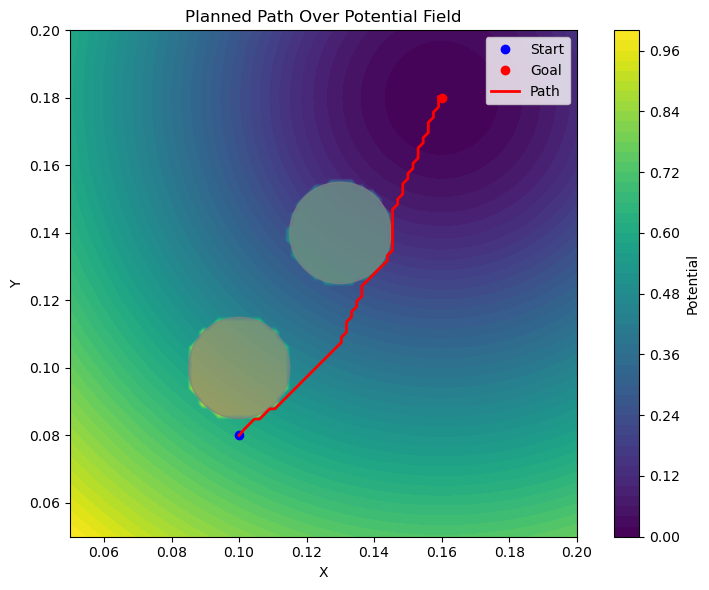

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, U_total, levels=50, cmap='viridis')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label("Potential")

# Plot start and goal
ax.plot(path[0, 0], path[0, 1], 'bo', label='Start')
ax.plot(q_d[0], q_d[1], 'ro', label='Goal')

# Plot the path
ax.plot(path[:, 0], path[:, 1], 'r-', linewidth=2, label='Path')

# Obstacles
for obs_center, obs_radius in obstacles:
    circle = plt.Circle(obs_center, obs_radius, color='gray', alpha=0.7)
    ax.add_patch(circle)

ax.set_title("Planned Path Over Potential Field")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


# Results

The results shown in the graph demonstrate a successful implementation of the potential field method for path planning. The robot clearly avoids the two circular obstacles. The path curves around the high-potential areas, showing that the repulsive fields are working effectively. The goal is located in a low-potential region, and the path moves steadily toward it, which means that the attractive potential is attracting the robot well. The generated path is relatively smooth and it avoids the local minima in our simple environment.